In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import seaborn as sns

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmaps
import contribution as contr

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
server='expanse'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/nfs/cw3e/cwp140/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## load PRISM and add WY coordinate
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
water_year = (PRISM.date.dt.month >= 10) + PRISM.date.dt.year
PRISM.coords['water_year'] = water_year

# ## use AR Scale as criteria for identifying AR at coast
# varname = 'ar_scale'
# thres = 0

# ## use Rutz AR dt for identifying AR at coast
# varname = 'ar'
# thres = 0

## use tARgetv4 AR dt for identifying AR at coast
varname = 'tARget'
thres = 0

HUC8_ID_lst = ['14010001', '14080101', '14050001'] ## Colorado Headwaters and Upper San Juan
HUC8_lbl_lst = ['Colorado Headwaters', 'Upper San Juan', 'Upper Yampa']
df_lst = []
df_lst2 = []
path_to_data = '/expanse/nfs/cw3e/cwp140/preprocessed/UCRB_trajectories/combined/'
for i, HUC8ID in enumerate(HUC8_ID_lst):
    df = contr.calculate_WY_contribution(path_to_data, PRISM, HUC8ID, varname, thres)
    df2 = contr.calculate_WY_contribution_total(path_to_data, PRISM, HUC8ID, varname, thres)
    df_lst.append(df)
    df_lst2.append(df2)

In [5]:
df_lst

[                HUC8  Total Precipitation  AR Associated    Percent
 water_year                                                         
 2000        14010001             87.25410            NaN        NaN
 2001        14010001             47.61250       13.50530  28.365030
 2002        14010001             31.72960            NaN        NaN
 2003        14010001            184.03070       33.48320  18.194356
 2004        14010001             63.62801       26.72910  42.008386
 2005        14010001            153.33243       47.44400  30.941921
 2006        14010001            134.97142       14.95960  11.083532
 2007        14010001            143.25412       47.20130  32.949349
 2008        14010001            148.70010       32.52690  21.874161
 2009        14010001             53.22230       13.12370  24.658273
 2010        14010001             74.34820            NaN        NaN
 2011        14010001            187.85770       78.53310  41.804568
 2012        14010001             

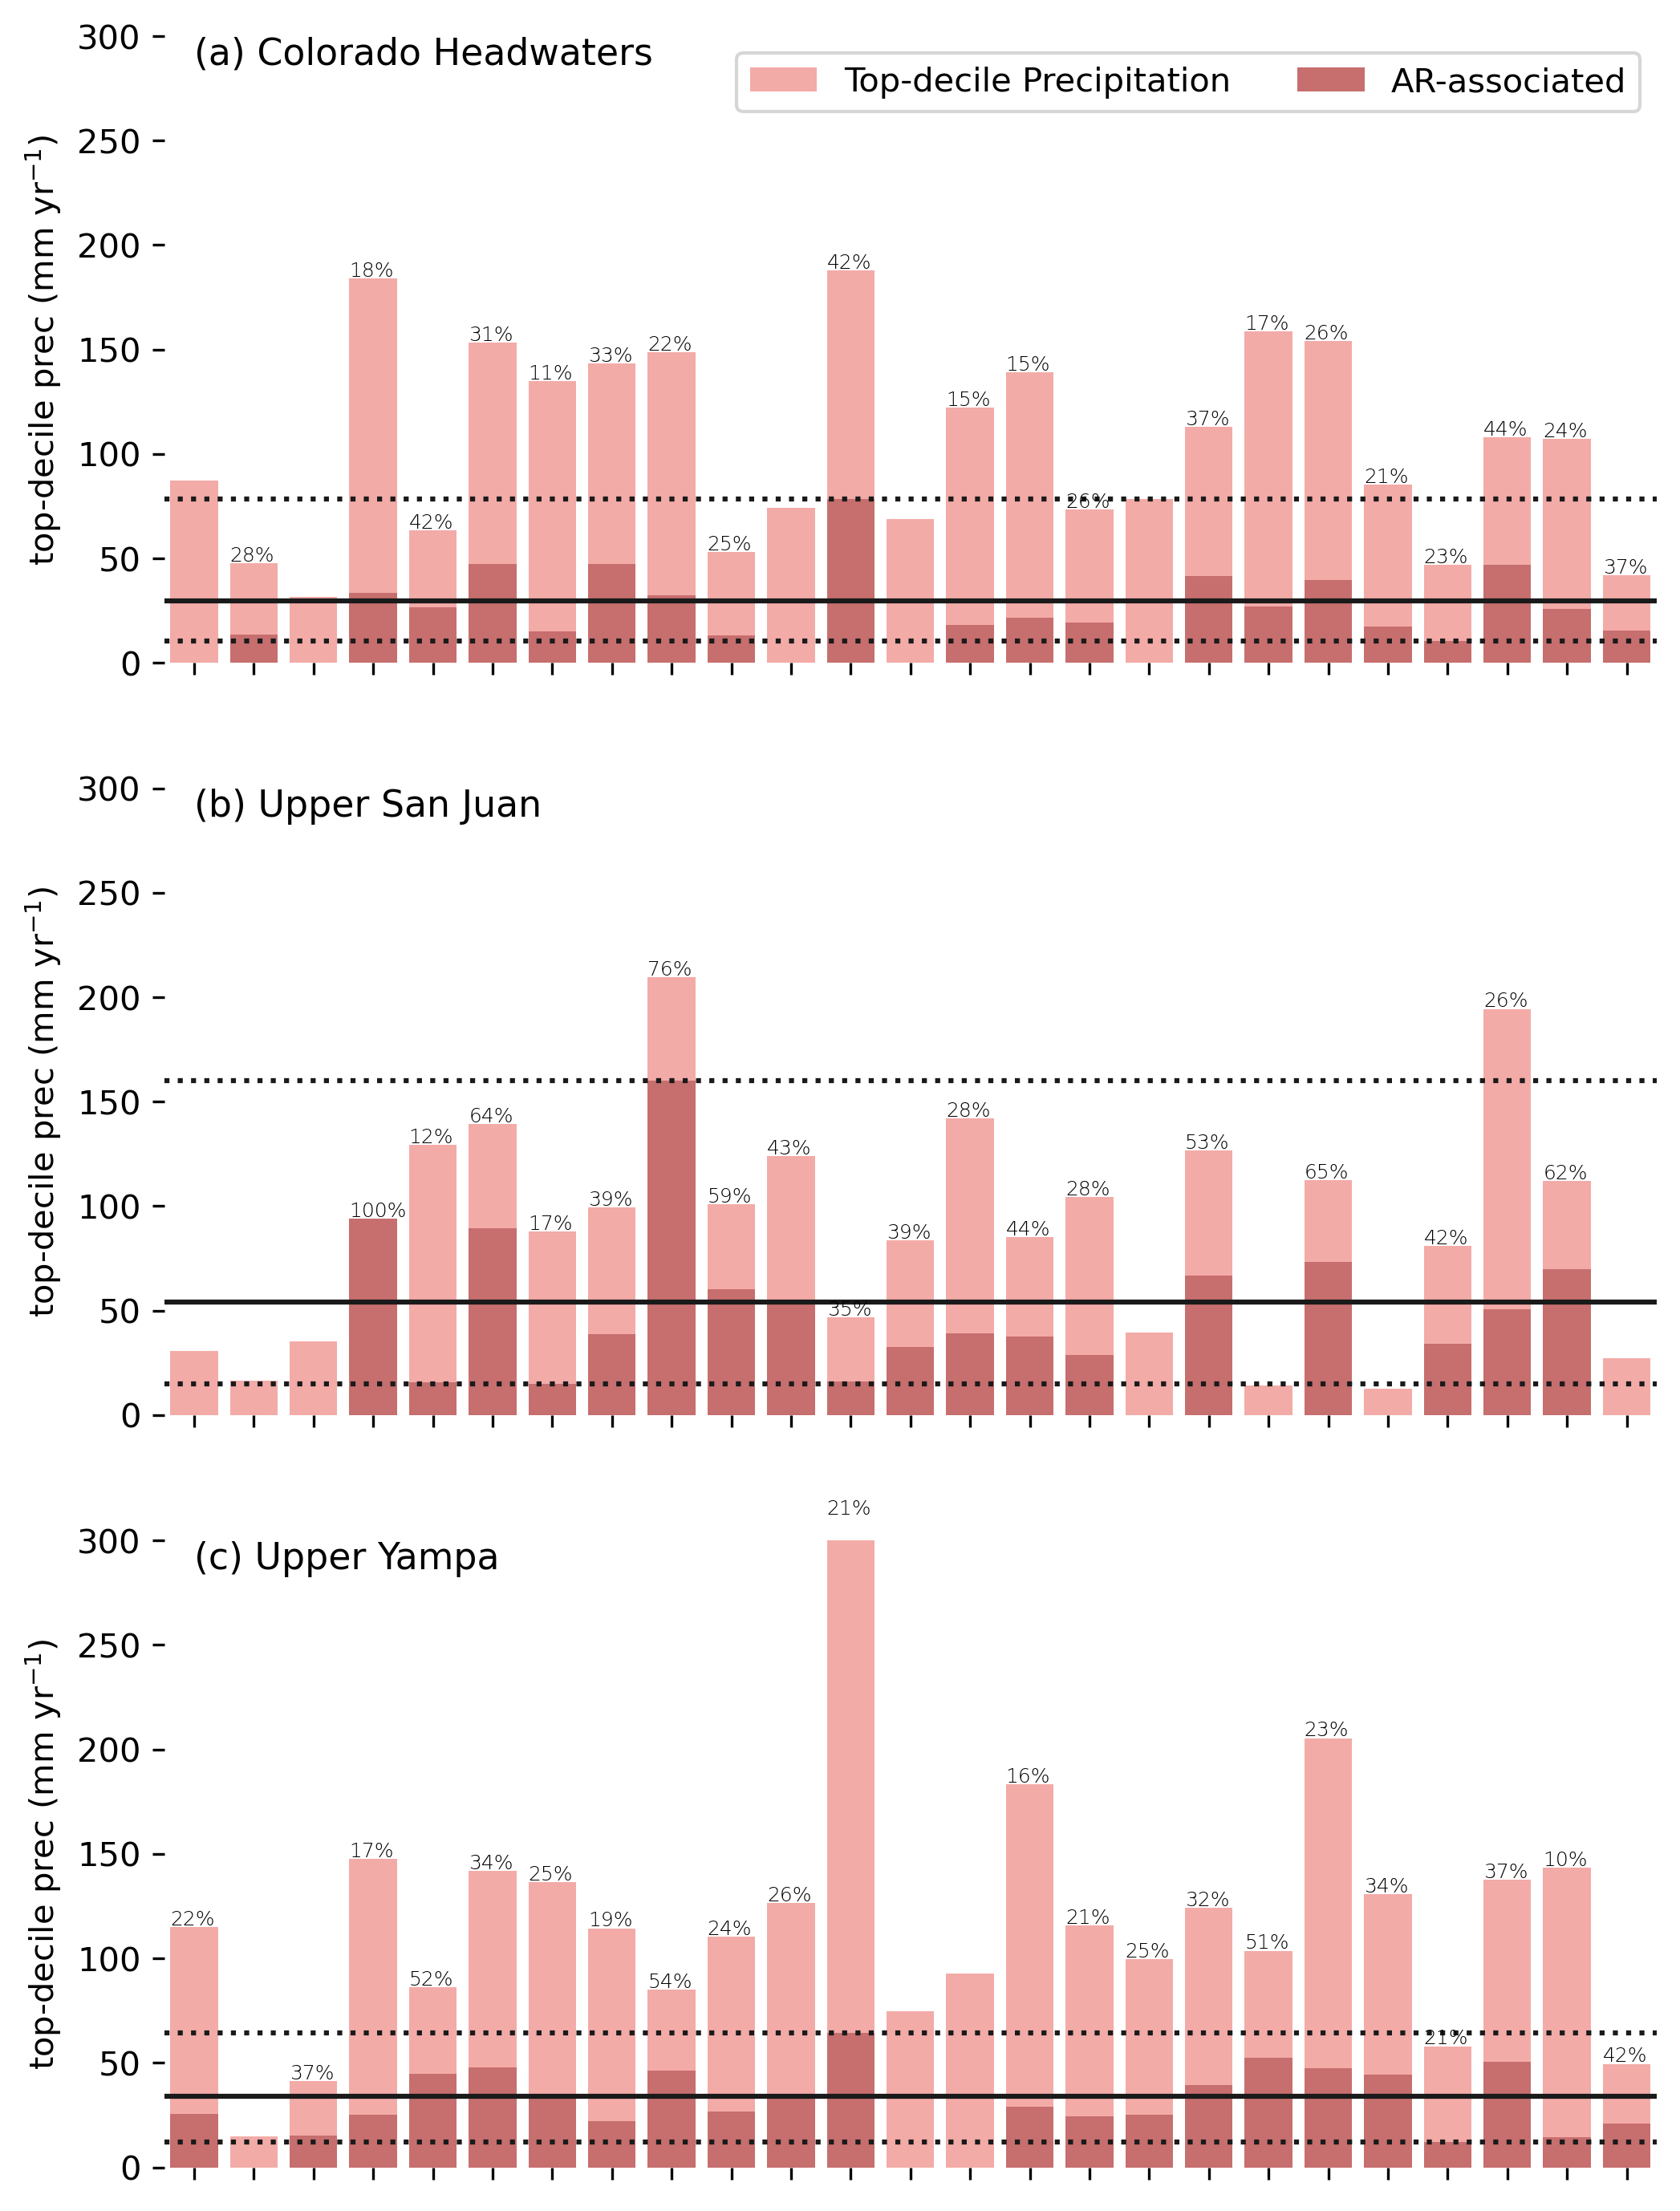

In [6]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
fig = plt.figure(figsize=(8,11.5))
fig.dpi = 300
fname = '../figs/time_series_top-decile_UCRC'
fmt1 = 'png'

nrows = 3
ncols = 1
gs = fig.add_gridspec(nrows, ncols)
color_list = ['b', 'r', 'g']

for k, df in enumerate(df_lst):
    ## Initialize the matplotlib figure
    ax = fig.add_subplot(gs[k, 0])
    
    # Plot the total precip
    sns.set_color_codes("pastel")
    d1 = sns.barplot(x=df.index, y="Total Precipitation", data=df, color='r', label="Top-decile Precipitation")
    
    # Plot the precipitation where ARs were involved
    sns.set_color_codes("muted")
    d2 = sns.barplot(x=df.index, y="AR Associated", data=df, color='r', label="AR-associated")
    
    # Add a legend and informative axis label
    ax.set(ylim=(0, 300), ylabel="top-decile prec (mm yr$^{-1}$)", xlabel="")
    sns.despine(left=True, bottom=True)
    #     ax.set_title(subtitles[i])

    ## add min/max/mean/median lines
    ax.axhline(y=df['AR Associated'].min(), color='k', linestyle=':')
    ax.axhline(y=df['AR Associated'].max(), color='k', linestyle=':') 
    ax.axhline(y=df['AR Associated'].mean(), color='k', linestyle='-')

    yloc = df['Total Precipitation'].values
    xloc = np.arange(0, len(df), 1)
    proportion = df['Percent'].values
    for i, (x, prop) in enumerate(zip(xloc, proportion)):
        if prop > 0:
            plt.text(x=x-0.4,
                     y=yloc[i]+1,
                     s=f'{int(np.round(prop, 0))}%',
                     color="black",
                     fontsize=6,
                     fontweight="light", zorder=200)
    
    if k == 0:
        ax.legend(ncol=2, loc="upper right", frameon=True)
    else:
        ax.get_legend().remove()
    
    if k == 3:
        d1.set_xticklabels(d1.get_xticklabels(), rotation=45)
        ax.set(xlabel="Water Year (October 1 - September 30)")
    else:
        ax.tick_params(labelbottom=False)

    titlestring = '({0}) {1}'.format(letter_lst[k], HUC8_lbl_lst[k])
    ax.text(0.02, 1., titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()

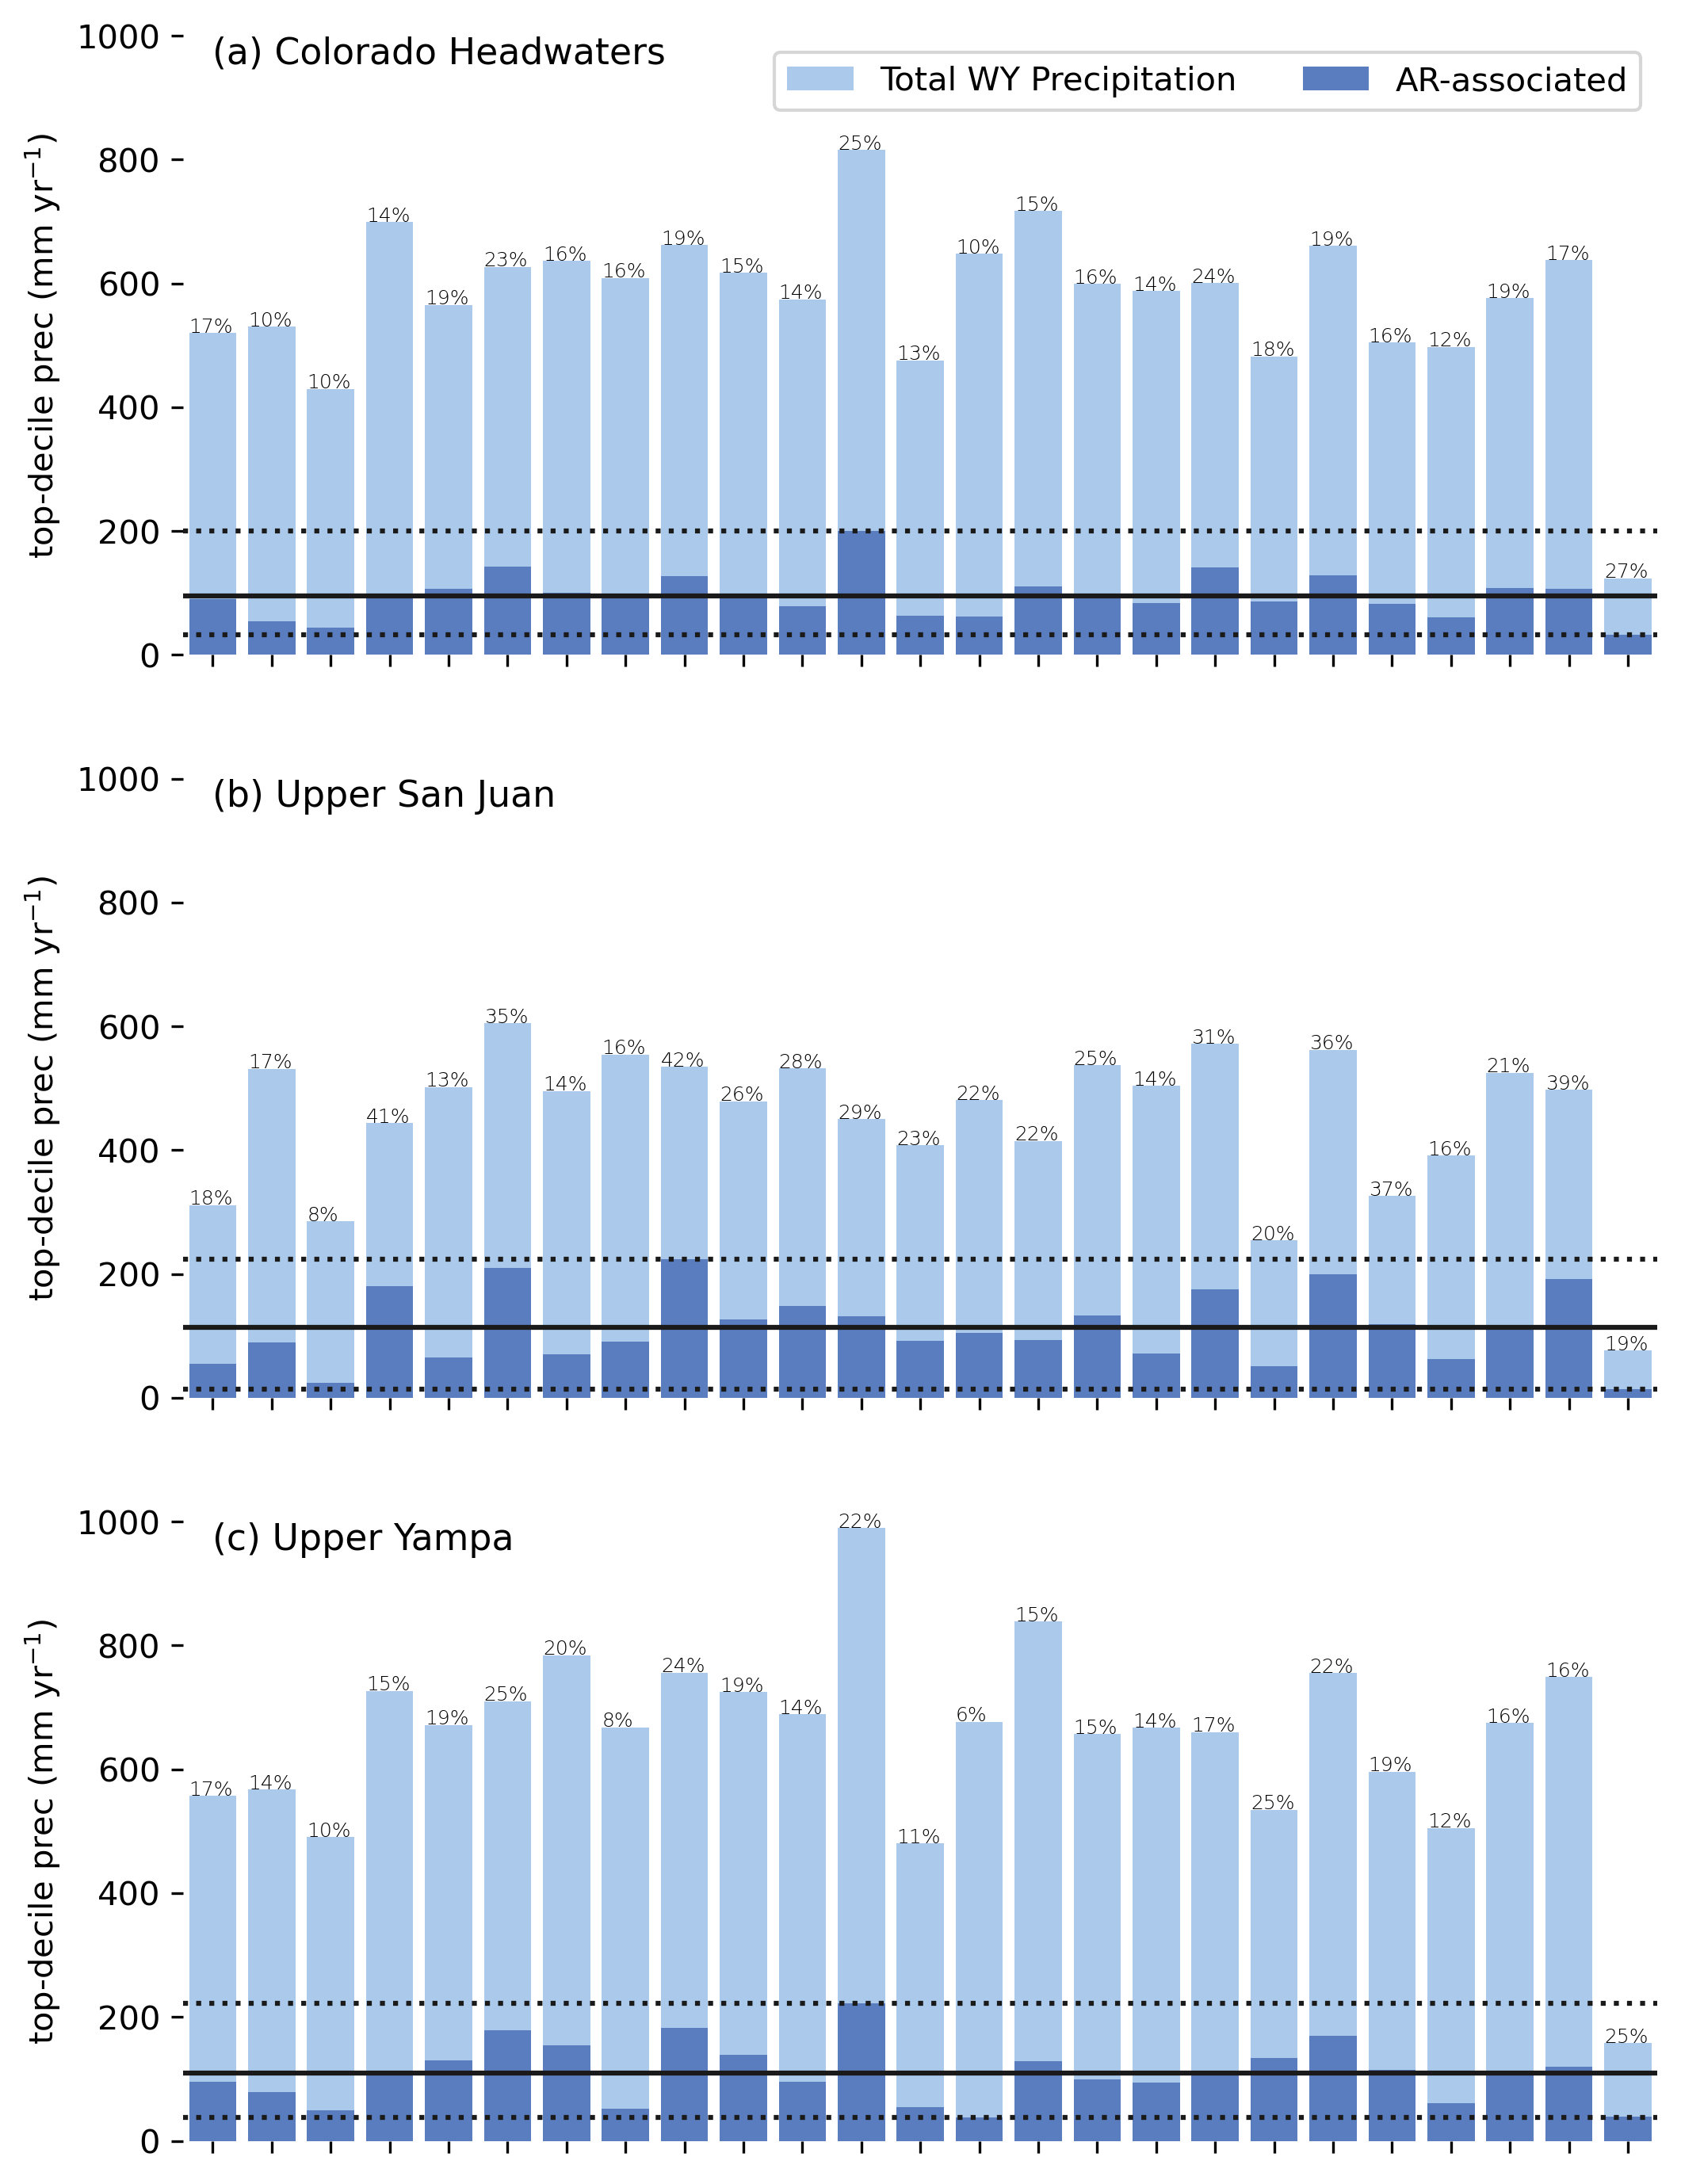

In [7]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
fig = plt.figure(figsize=(8,11.5))
fig.dpi = 300
fname = '../figs/time_series_all_UCRC'
fmt1 = 'png'

nrows = 3
ncols = 1
gs = fig.add_gridspec(nrows, ncols)
color_list = ['b', 'r', 'g']

for k, df in enumerate(df_lst2):
    ## Initialize the matplotlib figure
    ax = fig.add_subplot(gs[k, 0])
    
    # Plot the total precip
    sns.set_color_codes("pastel")
    d1 = sns.barplot(x=df.index, y="Total Precipitation", data=df, color='b', label="Total WY Precipitation")
    
    # Plot the precipitation where ARs were involved
    sns.set_color_codes("muted")
    d2 = sns.barplot(x=df.index, y="AR Associated", data=df, color='b', label="AR-associated")
    
    # Add a legend and informative axis label
    ax.set(ylim=(0, 1000), ylabel="top-decile prec (mm yr$^{-1}$)", xlabel="")
    sns.despine(left=True, bottom=True)
    #     ax.set_title(subtitles[i])

    ## add min/max/mean/median lines
    ax.axhline(y=df['AR Associated'].min(), color='k', linestyle=':')
    ax.axhline(y=df['AR Associated'].max(), color='k', linestyle=':') 
    ax.axhline(y=df['AR Associated'].mean(), color='k', linestyle='-')

    yloc = df['Total Precipitation'].values
    xloc = np.arange(0, len(df), 1)
    proportion = df['Percent'].values
    for i, (x, prop) in enumerate(zip(xloc, proportion)):
        if prop > 0:
            plt.text(x=x-0.4,
                     y=yloc[i]+1,
                     s=f'{int(np.round(prop, 0))}%',
                     color="black",
                     fontsize=6,
                     fontweight="light", zorder=200)
    
    if k == 0:
        ax.legend(ncol=2, loc="upper right", frameon=True)
    else:
        ax.get_legend().remove()
    
    if k == 3:
        d1.set_xticklabels(d1.get_xticklabels(), rotation=45)
        ax.set(xlabel="Water Year (October 1 - September 30)")
    else:
        ax.tick_params(labelbottom=False)

    titlestring = '({0}) {1}'.format(letter_lst[k], HUC8_lbl_lst[k])
    ax.text(0.02, 1., titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()